<a href="https://colab.research.google.com/github/gopala-03/laryngeal-tumor-detection/blob/main/IP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 1 - **MODEL BUILDING**

In [ ]:
# Import necessary modules
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [ ]:
%matplotlib inline

# Cropping Larynx Contour in Images

In [ ]:
# Function to crop the larynx contour in images
def crop_larynx_contour(image, plot=False):
    # Convert the image to grayscale and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions and dilations
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in the thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop a new image out of the original image using the four extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.title('Cropped Image')

        plt.show()

    return new_image

# Loading Data

In [ ]:
# Function to load and preprocess the laryngeal tumor dataset
def load_laryngeal_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_larynx_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.0
            X.append(image)

            if directory.endswith('IP'):
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
# Define the image size
IMG_WIDTH, IMG_HEIGHT = (240, 240)

# Load laryngeal tumor data
laryngeal_tumor_dir = 'IP/laryngeal_tumor'
non_tumor_dir = 'IP/non_tumor'

X_laryngeal, y_laryngeal = load_laryngeal_data([laryngeal_tumor_dir, non_tumor_dir], (IMG_WIDTH, IMG_HEIGHT))


Number of examples is: 28
X shape is: (28, 240, 240, 3)
y shape is: (28, 1)


# Splitting Data

In [ ]:
# Split the data
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train_laryngeal, y_train_laryngeal, X_val_laryngeal, y_val_laryngeal, X_test_laryngeal, y_test_laryngeal = split_data(X_laryngeal, y_laryngeal, test_size=0.3)


# **Laryngeal Tumor Detection** Model Builiding

In [ ]:
# Build the laryngeal tumor detection model
def build_laryngeal_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    X = MaxPooling2D((4, 4), name='max_pool1')(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    model = Model(inputs=X_input, outputs=X, name='LaryngealTumorDetectionModel')
    return model

In [ ]:
# Define the image shape
IMG_SHAPE_LARYNGEAL = (IMG_WIDTH, IMG_HEIGHT, 3)
model_laryngeal = build_laryngeal_model(IMG_SHAPE_LARYNGEAL)
model_laryngeal.summary()

# Compile the model
model_laryngeal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "LaryngealTumorDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 244, 244, 3)       0         
 g2D)                                                            
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                      

In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

# Training the Model

In [ ]:
# Train the model
start_time = time.time()
model_laryngeal.fit(x=X_train_laryngeal, y=y_train_laryngeal, batch_size=32, epochs=10, validation_data=(X_val_laryngeal, y_val_laryngeal))
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

# Train for more epochs
start_time = time.time()
model_laryngeal.fit(x=X_train_laryngeal, y=y_train_laryngeal, batch_size=32, epochs=10, validation_data=(X_val_laryngeal, y_val_laryngeal))
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.5915 - accuracy: 0.7368 - val_loss: 0.3613 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.2778 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 8.6935e-05 - accuracy: 1.0000 - val_loss: 0.2261 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 6.1624e-06 - accuracy: 1.0000 - val_loss: 0.1890 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 8.9060e-07 - accuracy: 1.0000 - val_loss: 0.1603 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 2.0746e-07 - accuracy: 1.0000 - val_loss: 0.1365 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 6.7865e-08 - accuracy: 1.0000 - val_loss: 0.1169 - val_accuracy: 1.0000
Epoch 8/10
1/1 [=====

# Loss and Accuracy

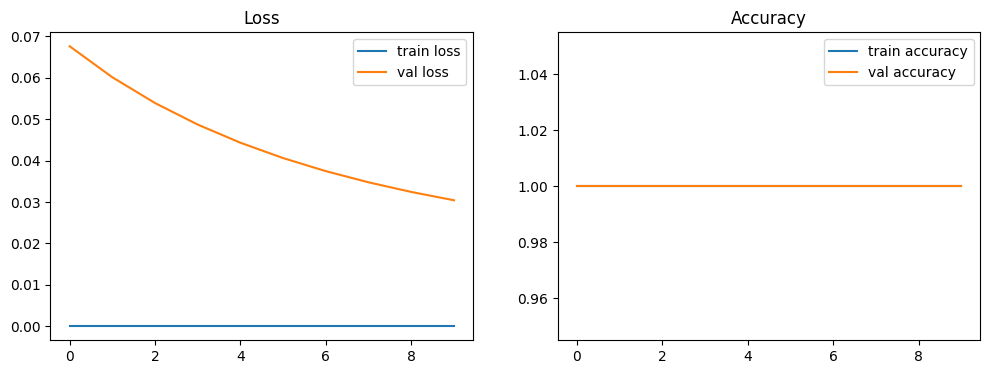

In [ ]:
# Plot loss and accuracy
history_laryngeal = model_laryngeal.history.history

def plot_metrics(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.legend()
    plt.title('Loss')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train accuracy')
    plt.plot(val_acc, label='val accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

plot_metrics(history_laryngeal)

# Evaluating and Saving the Model

In [ ]:
# Evaluate the model on the test set
preds_laryngeal = model_laryngeal.evaluate(x=X_test_laryngeal, y=y_test_laryngeal)
print ("Test Loss = " + str(preds_laryngeal[0]))
print ("Test Accuracy = " + str(preds_laryngeal[1]))

1/1 [==============================] - 0s 119ms/step - loss: 0.0284 - accuracy: 1.0000
Test Loss = 0.02836655266582966
Test Accuracy = 1.0


In [ ]:
# Make predictions on the test set
y_test_pred_laryngeal = model_laryngeal.predict(X_test_laryngeal)

# Define a function to convert model predictions to binary labels
def binary_classification(prediction, threshold=0.5):
    return 1 if prediction > threshold else 0

# Convert model predictions to binary labels
y_test_pred_binary_laryngeal = [binary_classification(p) for p in y_test_pred_laryngeal]

# Calculate F1 score
f1 = f1_score(y_test_laryngeal, y_test_pred_binary_laryngeal)
print("F1 Score: {:.2f}".format(f1))

1/1 [==============================] - 0s 216ms/step
F1 Score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
# Save the model
model_laryngeal.save('laryngeal_tumor_detection_model.h5')

# To load the model in the future, use:
# loaded_model = load_model('laryngeal_tumor_detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# PART 2 - **TUMOR DETECTION AND VISUALISATION**

In [ ]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt

# Function to detect and draw bounding boxes around tumors

In [ ]:
# Function to detect and draw bounding boxes around tumors
def detect_and_draw_tumor(image):
    # Convert the image to grayscale and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions and dilations
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # Loop over the contours
    for c in cnts:
        # If the contour area is larger than a threshold (adjust as needed)
        if cv2.contourArea(c) > 100:
            # Get the coordinates of the bounding box
            x, y, w, h = cv2.boundingRect(c)
            # Draw a rectangle around the detected tumor
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return image

In [ ]:
# Example usage:
laryngeal_tumor_dir = 'IP/laryngeal_tumor'
non_tumor_dir = 'IP/non_tumor'

X_laryngeal, y_laryngeal = load_laryngeal_data([laryngeal_tumor_dir, non_tumor_dir], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 28
X shape is: (28, 240, 240, 3)
y shape is: (28, 1)


In [ ]:
# Example of how to use the detect_and_draw_tumor function
image_index = 0  # Change this to the index of the image you want to visualize
original_image = X_test_laryngeal[image_index]

# Convert the image to the correct data type
original_image = (original_image * 255).astype(np.uint8)
print(f"Image shape: {original_image.shape}")
print(f"Image data type: {original_image.dtype}")
cropped_image = crop_larynx_contour(original_image)
tumor_detected_image = detect_and_draw_tumor(cropped_image)

Image shape: (240, 240, 3)
Image data type: uint8


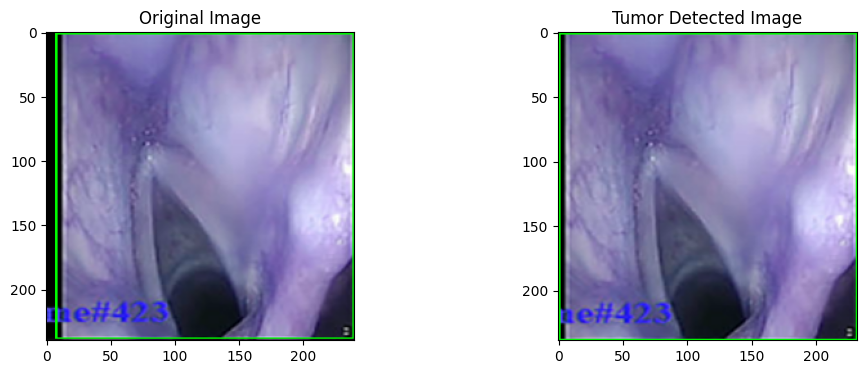

In [ ]:
# Display the images using matplotlib
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(tumor_detected_image)
plt.title('Tumor Detected Image')
plt.show()

# Defining the detect_and_draw_tumor function

In [ ]:
# Define the detect_and_draw_tumor function
def detect_and_draw_tumor(image, contours):
    # Make a copy of the input image to draw on
    image_with_circles = image.copy()

    # Draw circles around each detected tumor
    for contour in contours:
        # Calculate the center and radius of the minimum enclosing circle for the contour
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)

        # Draw the circle in red
        cv2.circle(image_with_circles, center, radius, (0, 0, 255), 2)

    return image_with_circles

In [ ]:
# Load your specific image
image_path = '/content/IP/laryngeal_tumor/right vocal fold cancer.png'
image1 = cv2.imread(image_path)

if image1 is not None:
    # Convert the image to the correct data type (if needed)
    image = (image1 * 255).astype(np.uint8)

    # Check the image shape and data type
    print(f"Image shape: {image.shape}")
    print(f"Image data type: {image.dtype}")

    # Proceed with your image processing and analysis here
else:
    print("Failed to load the image. Check the image path.")

Image shape: (210, 242, 3)
Image data type: uint8


In [ ]:
# Process and detect tumors in the image
cropped_image = crop_larynx_contour(image)

# Assuming you have contours obtained by some detection method (replace with your actual contours)
# For demonstration, I'll create a sample contour.
# contours should be a list of detected contours.
contours = [np.array([[[50, 50]], [[50, 100]], [[100, 100]], [[100, 50]]])]

# Draw circles around detected tumors
tumor_detected_image = detect_and_draw_tumor(cropped_image, contours)

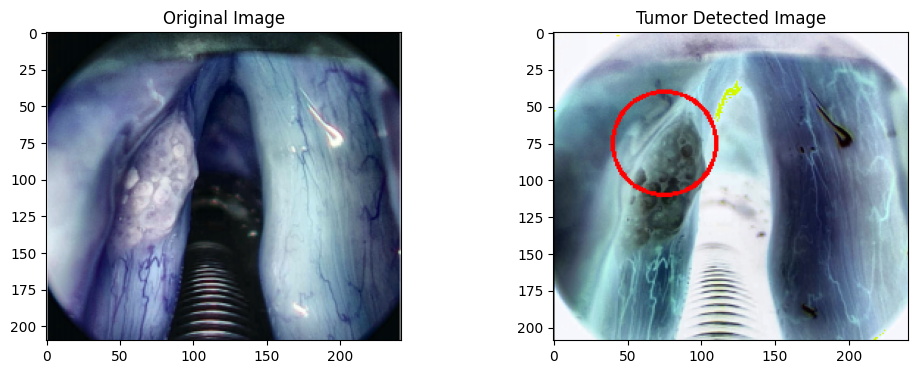

In [ ]:
# Display the original image, cropped image, and tumor-detected image
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(tumor_detected_image, cv2.COLOR_BGR2RGB))
plt.title('Tumor Detected Image')

plt.show()

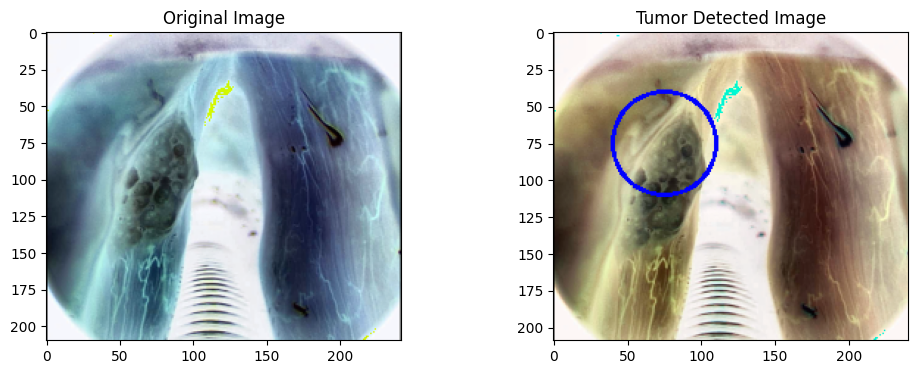

In [ ]:
# Display the original image, cropped image, and tumor-detected image
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(tumor_detected_image)
plt.title('Tumor Detected Image')

plt.show()

# PART 3 - **EVALUATION**

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Make predictions on the test set
y_test_pred_laryngeal = model_laryngeal.predict(X_test_laryngeal)

# Convert model predictions to binary labels
y_test_pred_binary_laryngeal = [binary_classification(p) for p in y_test_pred_laryngeal]

# Calculate F1 score
f1 = f1_score(y_test_laryngeal, y_test_pred_binary_laryngeal)
print("F1 Score: {:.2f}".format(f1))

1/1 [==============================] - 0s 188ms/step
F1 Score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
# Get the classification report
classification_rep = classification_report(y_test_laryngeal, y_test_pred_binary_laryngeal)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test_laryngeal, y_test_pred_laryngeal)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_laryngeal, y_test_pred_laryngeal)
average_precision = average_precision_score(y_test_laryngeal, y_test_pred_laryngeal)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


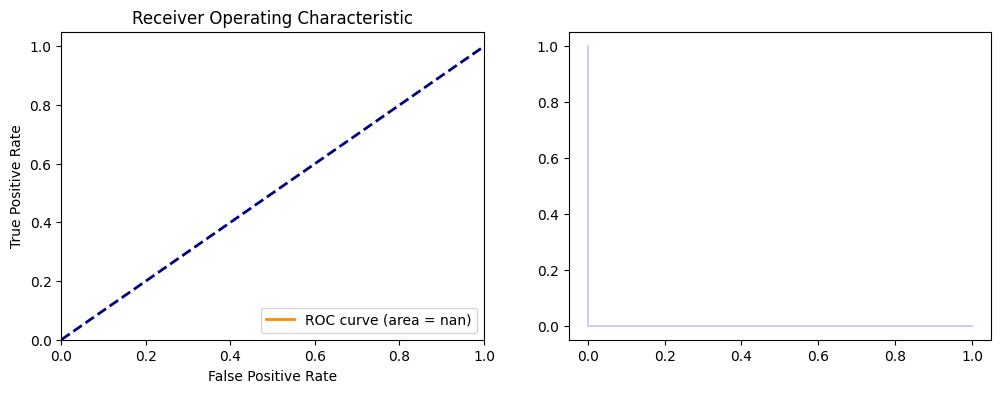

In [ ]:
# Plot ROC curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.step(recall, precision, color='b', alpha=0.2, where='post')